In [532]:
# Import all the necessary packages and libraries

%matplotlib inline
import csv
import re
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from collections import Counter
from joblib import dump, load
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearn_pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression,chi2,f_classif
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier


In [533]:
# Read in all CSV datasets to be used

accident = pd.read_csv ("Road Safety Data - Accidents 2019.csv")
Casualties = pd.read_csv ("Road Safety Data - Casualties 2019.csv")
Vehicles = pd.read_csv ("Road Safety Data- Vehicles 2019.csv")

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [534]:
# View the accident info
accident.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               117536 non-null  object 
 1   Location_Easting_OSGR                        117508 non-null  float64
 2   Location_Northing_OSGR                       117508 non-null  float64
 3   Longitude                                    117508 non-null  float64
 4   Latitude                                     117508 non-null  float64
 5   Police_Force                                 117536 non-null  int64  
 6   Accident_Severity                            117536 non-null  int64  
 7   Number_of_Vehicles                           117536 non-null  int64  
 8   Number_of_Casualties                         117536 non-null  int64  
 9   Date                                         117536 non-nul

In [535]:
# Count the number of empty entries in each attribute
accident.isnull().sum()

Accident_Index                                    0
Location_Easting_OSGR                            28
Location_Northing_OSGR                           28
Longitude                                        28
Latitude                                         28
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                             63
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

In [536]:
Vehicles.isnull().sum()

Accident_Index                      0
Vehicle_Reference                   0
Vehicle_Type                        0
Towing_and_Articulation             0
Vehicle_Manoeuvre                   0
Vehicle_Location-Restricted_Lane    0
Junction_Location                   0
Skidding_and_Overturning            0
Hit_Object_in_Carriageway           0
Vehicle_Leaving_Carriageway         0
Hit_Object_off_Carriageway          0
1st_Point_of_Impact                 0
Was_Vehicle_Left_Hand_Drive?        0
Journey_Purpose_of_Driver           0
Sex_of_Driver                       0
Age_of_Driver                       0
Age_Band_of_Driver                  0
Engine_Capacity_(CC)                0
Propulsion_Code                     0
Age_of_Vehicle                      0
Driver_IMD_Decile                   0
Driver_Home_Area_Type               0
Vehicle_IMD_Decile                  0
dtype: int64

In [537]:
Vehicles ['Junction_Location'].unique ()

array([-1,  0,  1,  2,  4,  6,  8,  5,  7,  3])

In [538]:
accident ['Junction_Control'].unique ()

array([ 2, -1,  4,  3,  1,  0])

### Dictionaries for data visualization

In [539]:
# Creating new dictionaries to help and aid easy exploratory data analysis

Vehicle_dicts = {1: "Pedal cycle", 2: "Motorcycle 50cc and under", 3: "Motorcycle 125cc and under",
                 4: "Motorcycle over 125cc and up to 500cc", 5: "Motorcycle over 500cc",
                 8: "Taxi/Private hire car", 9: "Car", 10: "Minibus (8 - 16 passenger seats)",
                 11: "Bus or coach (17 or more pass seats)", 16: "Ridden horse", 
                 17: "Agricultural vehicle", 18: "Tram", 19: "Van / Goods 3.5 tonnes mgw or under",
                 20: "Goods over 3.5t. and under 7.5t", 21: "Goods 7.5 tonnes mgw and over",
                 22: "Mobility scooter", 23: "Electric motorcycle", 90: "Other vehicle",
                 97: "Motorcycle - unknown cc", 98: "Goods vehicle - unknown weight"}

age_band_driver_dicts = {1: "0 - 5", 2: "6 - 10", 3: "11 - 15", 4: "16 - 20", 5: "21 - 25",
                        6: "26 - 35", 7: "36 - 45", 8: "46 - 55", 9: "56 - 65",
                        10: "66 - 75", 11: "Over 75"}

Vehicle_manoeuvre_dicts = {1: "Reversing", 2: "Parked", 3: "Waiting to go - held up", 
                          4: "Slowing or stopping", 5: "Moving off", 6: "U-turn",
                          7: "Turning left", 8: "Waiting to turn left", 9: "Turning right",
                          10: "Waiting to turn right", 11: "Changing lane to left",
                          12: "Changing lane to right", 13: "Overtaking moving vehicle - offside",
                          14: "Overtaking static vehicle - offside", 15: "Overtaking - nearside",
                          16: "Going ahead left-hand bend", 17: "Going ahead right-hand bend",
                          18: "Going ahead other", 19:"Engine_Capacity_(CC)"}

is_Vehicle_left_hand_drive_dicts = {1: "No", 2: "Yes"}

weather_condition_dicts = {1: "Fine no high winds", 2: "Raining no high winds", 3: "Snowing no high winds",
                          4: "Fine + high winds", 5: "Raining + high winds", 6: "Snowing + high winds",
                          7: "Fog or mist", 8: "Other", 9: "Unknown"}

light_condition_dicts = {1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit",
                        6: "Darkness - no lighting", 7: "Darkness - lighting unknown"}

road_type_dicts = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway",
                   7: "Slip road", 9: "Unknown", 12: "One way street/Slip road"}

road_surface_dicts = {1: "Dry", 2: "Wet or damp", 3: "Snow", 4: "Frost or ice",
                      5: "Flood over 3cm. deep", 6: "Oil or diesel", 7: "Mud"}

journey_purpose_dicts = {1: "Journey as part of work", 2: "Commuting to/from work", 
                         3: "Taking pupil to/from school", 4: "Pupil riding to/from school",
                         5: "Other", 6: "Not known", 15: "Other/Not known (2005-10)"}




## Data Cleaning

- Dropping Location_Easting_OSGR, Location_Northing_OSGR because the longitude and latitude are enough for the geograpical location analysis

In [540]:
accident.drop (labels = ["Location_Easting_OSGR", "LSOA_of_Accident_Location",
                         "Location_Northing_OSGR"], axis=1, inplace=True)

- Checking the Light Coondition in the accident data, there is an occurence of a value as -1 which is  missing or out of range. This will be replaced with the time of the day (2:30pm) the record was taken which is 1 (Daylight)

In [541]:
accident [accident ['Light_Conditions']== -1]

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
117466,2019983103819,-3.615979,55.068927,98,3,1,1,11/02/2019,2,14:30,...,0,-1,-1,-1,1,-1,-1,-1,1,2


In [542]:
accident.at[117466, 'Light_Conditions'] = 1

In [543]:
accident [accident ['Light_Conditions']== -1]

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident


In [544]:
accident [accident ['Road_Type']== -1]

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident


- Creating functions to replacing all missing data and out of range values in the accident data

In [545]:
accident_missing_data = ["Speed_limit", "Junction_Detail", "Junction_Control", "Pedestrian_Crossing-Human_Control",
                         "Pedestrian_Crossing-Physical_Facilities", "Road_Surface_Conditions",
                         "Special_Conditions_at_Site", "Carriageway_Hazards"]

def find_data_with_authority_and_type_of_road (authority_local, type_of_road):
    
    accident_by_region = accident [(accident ["Local_Authority_(Highway)"] == authority_local) &
                                   (accident["Road_Type"] == type_of_road) & (~accident["Longitude"].isna ())]
    if (len (accident_by_region)>0):
        return accident_by_region.head(1)
    else:
        return None    

def find_replacement_with_type_of_road_and_authority (authority_local, type_of_road, allocate):
    
    accident_by_region = accident[(accident["Local_Authority_(Highway)"] == authority_local) & 
                                  (accident ["Road_Type"] == type_of_road) & (~accident[allocate].isna ())]
    if (len(accident_by_region)>0):
        return accident_by_region.head(1) [allocate]
    else:
        return None

#Missing cells in longitude and latitude were replaced with entires with similar local_authority and road type, because they are in the same geoloaction.
def find_replace_missing_location ():
    
    pointers = accident [accident ["Longitude"].isna ()].index
    for pnt in pointers:
        get_back_data = (find_data_with_authority_and_type_of_road(accident.iloc[pnt]
                        ["Local_Authority_(Highway)"], accident.iloc[pnt]["Road_Type"]))
        accident.at[pnt, "Longitude"] = get_back_data ["Longitude"]
        accident.at[pnt, "Latitude"] = get_back_data ["Latitude"]

def find_missing_location_with_value (allocate):
    pointers = accident[accident[allocate] == 1].index
    for pnt in pointers:
        get_back_data = (find_replacement_with_type_of_road_and_authority
                         (accidents.iloc[pnt]["Local_Authority_(Highway)"], 
                          accident.iloc[pnt]["Road_Type"], allocate))
        accident.at[pnt, attribute] = get_back_data
        
def attributes_replacement_based_with_location ():
    column_to_replace = ["Speed_limit", "Junction_Detail", "Pedestrian_Crossing-Human_Control",
                         "Pedestrian_Crossing-Physical_Facilities"]
    for allocate in column_to_replace:
        attributes_replacement_based_with_location (allocate)
        
def attribute_replacement_with_most_occuring_mode (df, allocation):
    for allocate in allocation:
        mode = df[allocate].mode()
        df.replace({allocate:{-1:mode}}, inplace = True)


In [546]:
find_replace_missing_location ()

In [547]:
attributes_replacement_with_mode_accident = ["Speed_limit", "Junction_Detail", "Junction_Control", 
                                    "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities",
                                    "Road_Surface_Conditions", "Special_Conditions_at_Site", "Carriageway_Hazards"]
attribute_replacement_with_most_occuring_mode (accident, attributes_replacement_with_mode_accident)


- Drop some attribute in the vehicle data because they contain lots of missing data and would not be necessary for analysis or prediction

In [548]:
Vehicles.drop(labels = ['Vehicle_IMD_Decile', 'Driver_Home_Area_Type', 'Driver_IMD_Decile', 
                       'Propulsion_Code', 'Age_of_Driver'], axis=1, inplace=True)

- Cleaning the Junction_location in the vehicle data where there were missing data and out of range values, using the forward and backward fill approach. Also converting all entries to integer

In [549]:
Vehicles.replace({"Junction_Location": {-1:np.nan}}, inplace = True)
Vehicles ["Junction_Location"].fillna(method = 'ffill', inplace = True)
Vehicles ["Junction_Location"].fillna(method = 'bfill', inplace = True)
Vehicles.replace({"Junction_Location": {'0.0':0, '1.0':1, '2.0':2, '3.0':3, '4.0':4,
                                        '5.0':5, '6.0':6, '7.0':7, '8.0':8}}, inplace = True)
Vehicles = Vehicles.astype ({'Junction_Location': int})

In [558]:
attributes_replacement_with_mode_vehicle = ['Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre',
                                            'Vehicle_Location-Restricted_Lane', 'Skidding_and_Overturning',
                                            'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway',
                                            'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 
                                            'Was_Vehicle_Left_Hand_Drive?', 'Journey_Purpose_of_Driver',
                                            'Sex_of_Driver', 'Age_Band_of_Driver']
attribute_replacement_with_most_occuring_mode (Vehicles, attributes_replacement_with_mode_vehicle)

- Cleaning and creating functions for the time in the accident data
- Cleaning the empty time using the forward fill approach

In [551]:
accident["Time"] = accident["Time"].fillna(method = 'ffill')

- The current time stamp format included with the accident data set are in (i.e., HH:MM). It is essential to convert the hours of the day to decimal format for convenience of use with seaborn or plt, in order to generate a histogram of accidents binned by hour of the day. This will be converted to decimal time (hours + minutes/60) format below using a function.

In [552]:
def convert_time_to_decimal (str_time):
    hrs_and_mins = re.split (':', str_time)
    hrs_and_mins = [int (t) for t in hrs_and_mins]
    return hrs_and_mins [0] + (hrs_and_mins[1]/60.0)

def time_to_decimal_accident ():
    for pnt in accident ["Time"].index:
        time_decimal = convert_time_to_decimal(accident.at[pnt, 'Time'])
        accident.at[pnt, 'time_decimal'] = round (time_decimal, 3)

def day_of_year_accident ():
    for pnt in accident ["Date"].index:
        date = accident.at [pnt, 'Date']
        str_date = re.split('/', date)
        int_date = [int (t) for t in str_date]
        value_date = dt.date (int_date[2], int_date[1], int_date [0]).timetuple().tm_yday
        accident.at[pnt, 'day_of_year'] = int(value_date)

In [553]:
time_to_decimal_accident()

In [554]:
day_of_year_accident ()

- Function for easy chart plots

In [555]:
def count_plt_drawn (dframe, attribute, size_fig = (10, 8), label_replace = False, label_new = None):
    value_unique = dframe[attribute].unique ().tolist()
    count_value = []
    count_total = len (dframe)
    for val in value_unique:
        count_row = dframe[dframe[attribute] == val][attribute].count()
        percent = round ((count_row/count_total)*100, 2)
        count_value.append (percent)
    if (label_replace and label_new != None):
        for n in range (len(value_unique)):
            val_new = label_new [value_unique[n]]
            if (val_new != None):
                value_unique [n] = val_new
    df = pd.DataFrame ({
        attribute : value_unique, 
        'Count': count_value
    })
    df = df.sort_values ('Count')
    ax = df.plot (kind = 'barh', x=attribute, y='Count', figsize=size_fig, zorder=2, width = 0.85 )
    ax.spines ['bottom'].set_visible (False)
    ax.spines ['top'].set_visible (False)
    ax.spines ['right'].set_visible (False)
    ax.spines ['left'].set_visible (False)
    ax.tick_params (axis = 'both', bottom = 'off',top = "off", labelbottom ='on',
                    left='off', right='off', labelleft='on')
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline (x=tick, linestyle='dashed', alpha=0.5, color = '#eeeeee', zorder=0)
    ax.set_xlabel ('Frequency (%)', labelpad=20, weight = 'bold', size=14)
    ax.set_ylabel (attribute, labelpad=20, weight='bold', size =14)


In [556]:
def hist_draw (data, show_kde, title_x_axis):
    fig, ax = plt.subplots (figsize = (10,8))
    sns.distplot (data, hist = True, kde = show_kde, color = "green")
    plt.xlabel (title_x_axis)
    plt.ylabel ("Density" if show_kde else "Count")

### (a) Are there significant hours of the day, and days of the week, on which accidents occur?

In [397]:
#Extracting the hours of the day from the time dataset and adding to the accident data
hour = []
for time in accident ['Time']:
    find_hour = time [:2]
    hour.append(find_hour)
    
accident['Hour'] = hour

In [398]:
accident_time = accident[['Date','Day_of_Week','Time']]

In [399]:
accident_time.head()

,Date,Day_of_Week,Time
0,18/02/2019,2,17:50
1,15/01/2019,3,21:45
2,01/01/2019,3,01:50
3,01/01/2019,3,01:20
4,01/01/2019,3,00:40


In [268]:
#creating the column, hour,day,month and year
#creating year column
def year(string):
    return int(string[6:10])
accident_time['Year']=accident_time['Date'].apply(lambda x: year(x))
#creating month column
def month(string):
    return int(string[3:5])
accident_time['Month']=accident_time['Date'].apply(lambda x: month(x))
#creating day column
def day(string):
    return int(string[0:2])
accident_time['Day']=accident_time['Date'].apply(lambda x: day(x))
#creating hour column
def hour(string):
    s=string[0:2]
    return int(s)
accident_time['Hour']=accident_time['Time'].apply(lambda x: hour(x))

<ipython-input-268-dbd3422173de>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_time['Year']=accident_time['Date'].apply(lambda x: year(x))
<ipython-input-268-dbd3422173de>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_time['Month']=accident_time['Date'].apply(lambda x: month(x))
<ipython-input-268-dbd3422173de>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

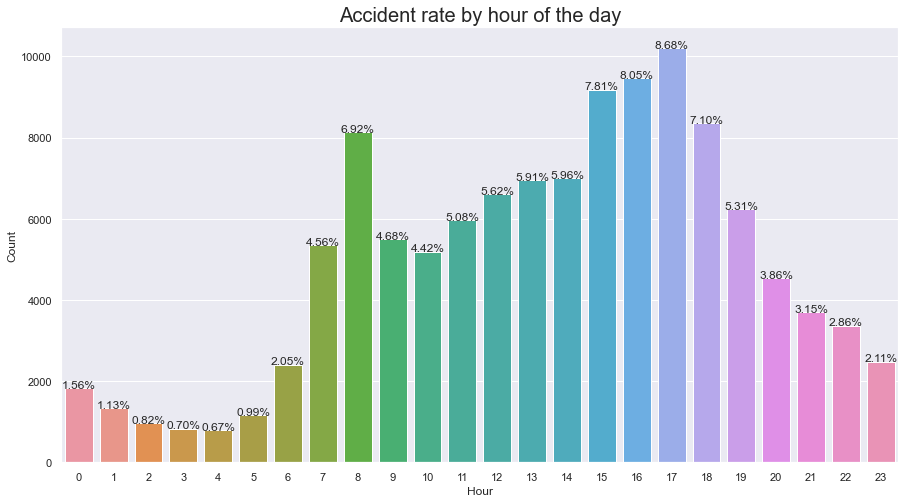

In [269]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title ('Accident rate by hour of the day', size=20)
acc_hour = sns.countplot(x='Hour',data=accident_time)
acc_hour.set(xlabel='Hour', ylabel='Count')
for p in acc_hour.patches: 
    height = p.get_height() 
    acc_hour.text(p.get_x()+p.get_width()/2., 
      height + 3, '{:1.2f}'.format((height/len(accident_time))*100)+'%', ha="center") 
plt.show()

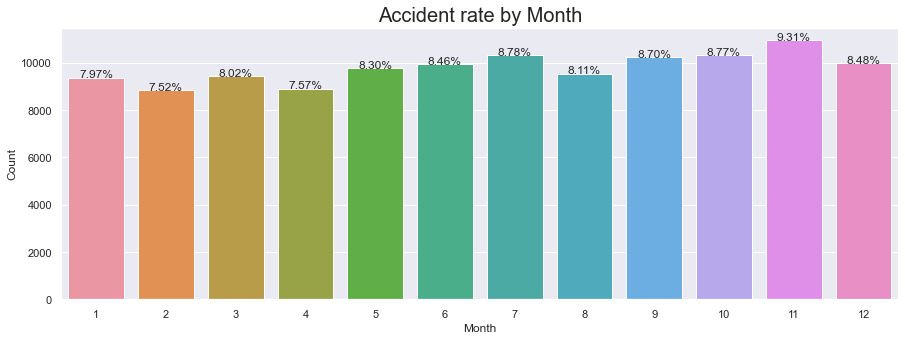

In [270]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
plt.title ('Accident rate by Month', size=20)
acc_month = sns.countplot(x='Month',data=accident_time)
acc_month.set(xlabel='Month', ylabel='Count')
for p in acc_month.patches: 
    height = p.get_height() 
    acc_month.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(accident_time))*100)+'%',  
      ha="center") 
plt.show()

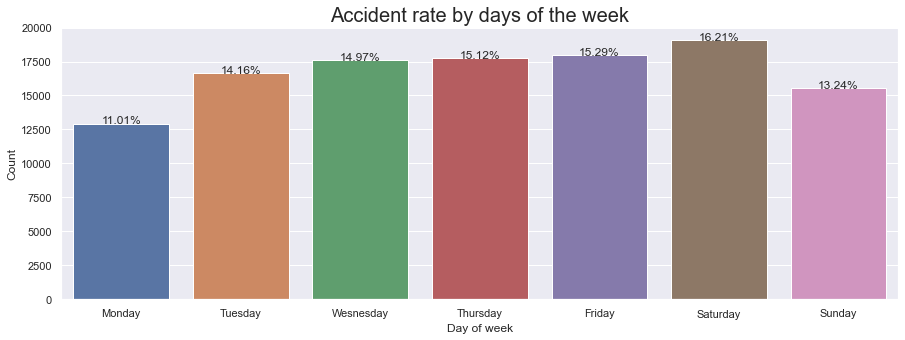

In [271]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
plt.title ('Accident rate by days of the week', size=20)
acc_week = sns.countplot(x='Day_of_Week',data=accident_time)
acc_week.set(xlabel='Day of week', ylabel='Count')
for p in acc_week.patches: 
    height = p.get_height() 
    acc_week.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(accident_time))*100)+'%', ha="center") 
acc_week.set(xticklabels=['Monday','Tuesday','Wesnesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

Text(0.5, 1.0, 'Accident rate by Time')

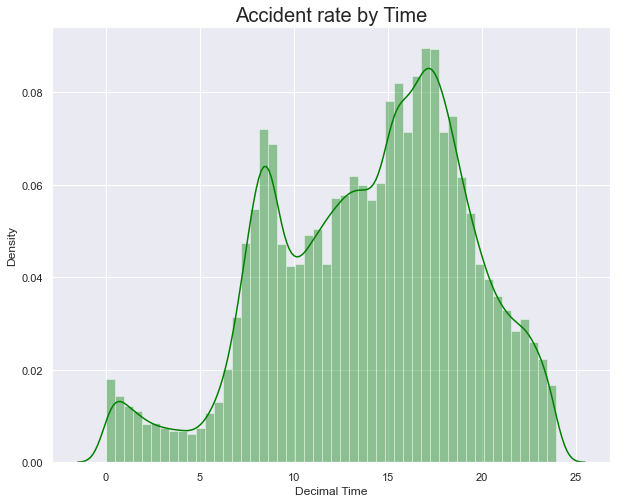

In [392]:
hist_draw (accident['time_decimal'], True, "Decimal Time")
plt.title ('Accident rate by Time', size=20)

<ipython-input-273-844ea2e6bd2a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_time['Ones']=1


<AxesSubplot:title={'center':'Accident by month vs days of the week'}, xlabel='Day_of_Week', ylabel='Month'>

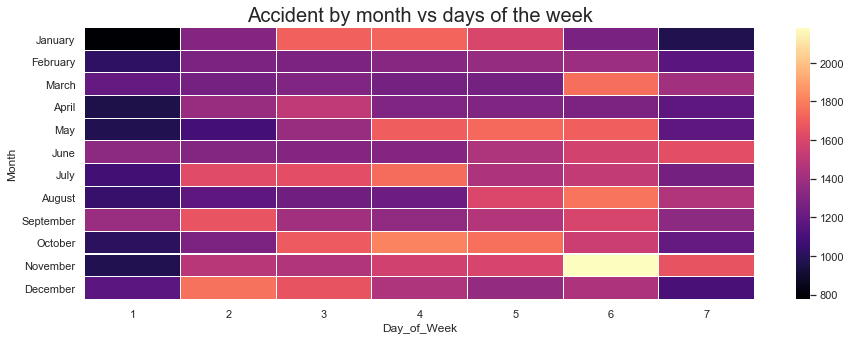

In [273]:
#Heatmap showing accidents by month versus the days of the week

accident_time['Ones']=1
table = pd.pivot_table(accident_time, values='Ones', index=['Month'],columns=['Day_of_Week'], aggfunc=np.sum)
plt.figure(figsize=(15,5))
plt.title ('Accident by month vs days of the week', size=20)
yticks = np.array(['January','February','March','April','May','June','July','August','September','October','November','December'])
sns.set(rc={"axes.labelsize":20},font_scale=1)
sns.heatmap(table, yticklabels=yticks,linewidths=.1,annot=False,cmap='magma')

### (b) For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur?

In [402]:
accident_Vehicles = pd.merge (Vehicles, accident, how='inner', on = "Accident_Index")


In [403]:
motor_bikes = accident_Vehicles [accident_Vehicles['Vehicle_Type'].isin ([2,3,4,5,23,97])]

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


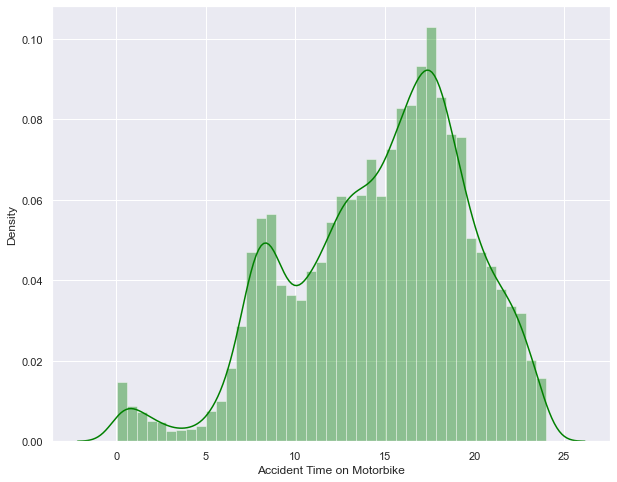

In [404]:
hist_draw(motor_bikes['time_decimal'], True, 'Accident Time on Motorbike')

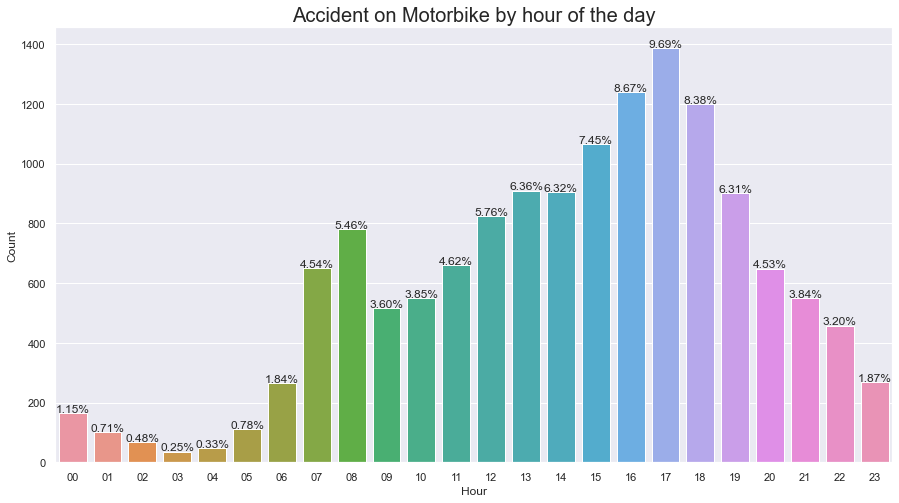

In [405]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title ('Accident on Motorbike by hour of the day', size=20)
acc_hour = sns.countplot(x='Hour',data=motor_bikes, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17'
                         ,'18','19','20','21','22','23'])
acc_hour.set(xlabel='Hour', ylabel='Count')
for p in acc_hour.patches: 
    height = p.get_height() 
    acc_hour.text(p.get_x()+p.get_width()/2., 
      height + 3, '{:1.2f}'.format((height/len(motor_bikes))*100)+'%', ha="center")
#acc_hour.set(xticklabels=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17'
                        # ,'18','19','20','21','22','23'])

plt.show()

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Accident rate on Motorbike by hour of the day')

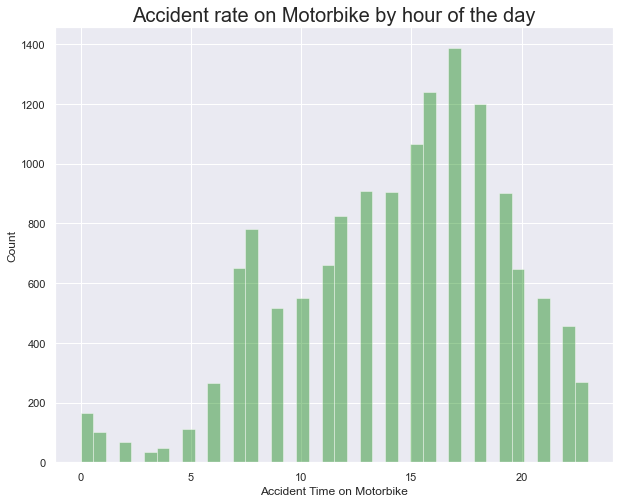

In [406]:
hist_draw(motor_bikes['Hour'], False, 'Accident Time on Motorbike')
plt.title ('Accident rate on Motorbike by hour of the day', size=20)


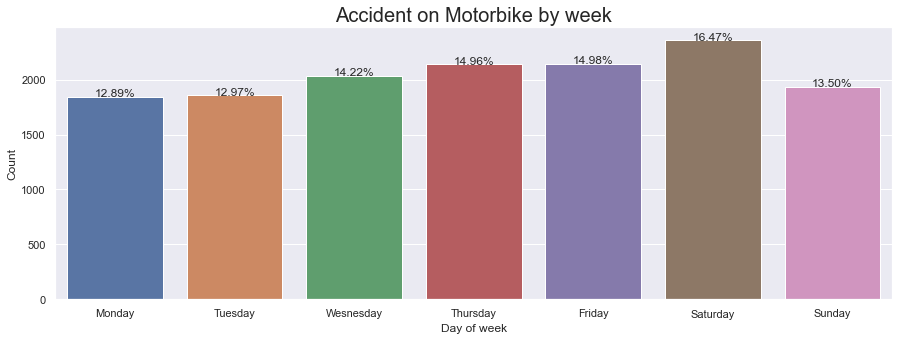

In [368]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
plt.title ('Accident on Motorbike by week', size=20)
acc_on_bike_week = sns.countplot(x='Day_of_Week',data=motor_bikes)
acc_on_bike_week.set(xlabel='Day of week', ylabel='Count')
for p in acc_on_bike_week.patches: 
    height = p.get_height() 
    acc_on_bike_week.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(motor_bikes))*100)+'%', ha="center") 
acc_on_bike_week.set(xticklabels=['Monday','Tuesday','Wesnesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

In [439]:
Accident_Severity_dict = {1: "Fatal", 2: "Serious", 3: "Slight"}

In [440]:
accident['Accident_Severity'].unique()

array([3, 2, 1])

In [441]:
motor_bikes.replace ({'Accident_Severity': Accident_Severity_dict}, inplace = True)


/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 1.0, 'Accident on Motorbike by severity')

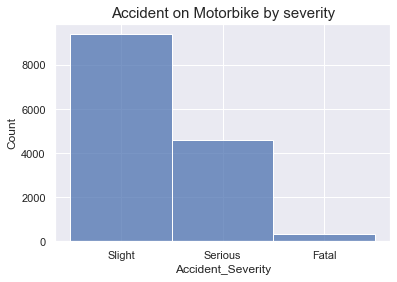

In [442]:
# Plot a chat to show accident severity on motor bike accident
sns.histplot(data = motor_bikes, x='Accident_Severity')
plt.title ('Accident on Motorbike by severity', size=15)

<AxesSubplot:title={'center':'Accident on Motorbike by Urban and Rural Area'}, xlabel='Accident_Severity', ylabel='count'>

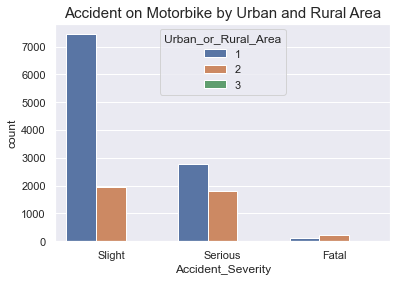

In [443]:
# Plot a chat to show accident severity on motor bike accident
plt.title ('Accident on Motorbike by Urban and Rural Area', size=15)
sns.countplot (data = motor_bikes, x='Accident_Severity', hue = "Urban_or_Rural_Area" )

### (c) For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [280]:
#Mearginf accident and casualty dataset on colunm accident index using inner join
accident_Casualties = pd.merge (Casualties, accident, how='inner', on = 'Accident_Index')

In [281]:
#To identify perdestrians in the accident_casualty data with 3 casualty classes
ped_involved = accident_Casualties [accident_Casualties['Casualty_Class'] ==3]

In [282]:
ped_involved.head()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,time_decimal,day_of_year,Hour
5,2019010155192,1,1,3,1,68,10,2,5,4,...,4,1,1,0,0,1,1,1.333,1.0,01
11,2019010155196,1,1,3,1,40,7,3,1,3,...,4,1,1,0,0,1,1,1.583,1.0,01
19,2019010155209,1,1,3,1,23,5,3,1,1,...,4,1,1,0,0,1,1,1.250,1.0,01
20,2019010155210,1,1,3,1,24,5,1,5,1,...,6,1,1,0,0,1,1,3.000,1.0,03
21,2019010155216,1,1,3,1,38,7,3,5,3,...,4,1,1,0,0,1,1,2.750,1.0,02


/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


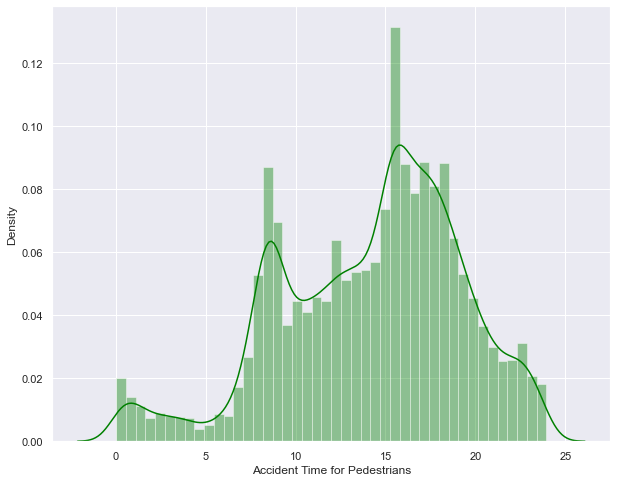

In [283]:
hist_draw(ped_involved['time_decimal'], True, 'Accident Time for Pedestrians')

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Accident time for by pedestrian by hours of the day')

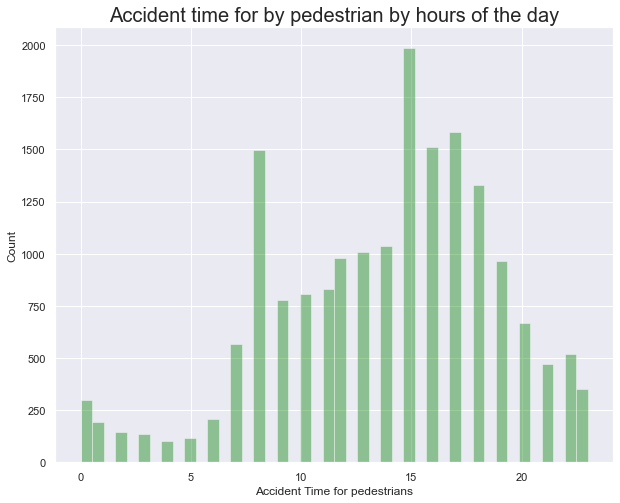

In [448]:
hist_draw (ped_involved['Hour'], False , 'Accident Time for pedestrians')
plt.title ('Accident time for by pedestrian by hours of the day', size=20)

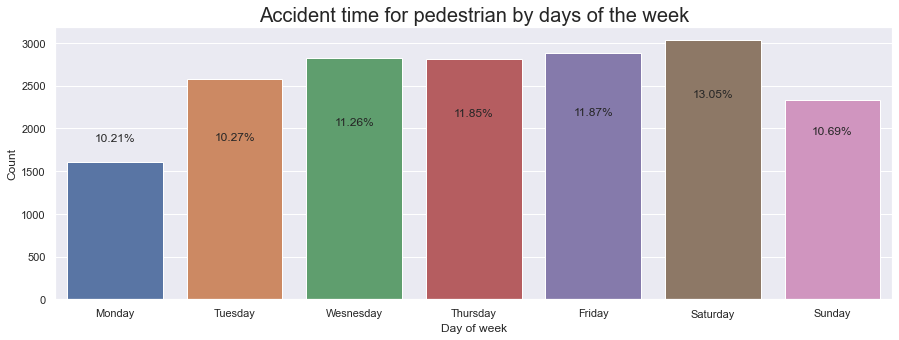

In [449]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,5))
plt.title ('Accident time for pedestrian by days of the week', size=20)
acc_by_ped_week = sns.countplot(x='Day_of_Week',data=ped_involved)
acc_by_ped_week.set(xlabel='Day of week', ylabel='Count')
for p in acc_on_bike_week.patches: 
    height = p.get_height() 
    acc_by_ped_week.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(ped_involved))*100)+'%', ha="center") 
acc_by_ped_week.set(xticklabels=['Monday','Tuesday','Wesnesday','Thursday','Friday','Saturday','Sunday'])
plt.show()

In [444]:
Sex_of_Casualty_dict = {1: "Male", 2:"Female", -1: "Unknown"}

In [445]:
ped_involved.replace ({'Sex_of_Casualty': Sex_of_Casualty_dict}, inplace = True)


/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Text(0.5, 1.0, 'Accident involving pedestrians by gender')

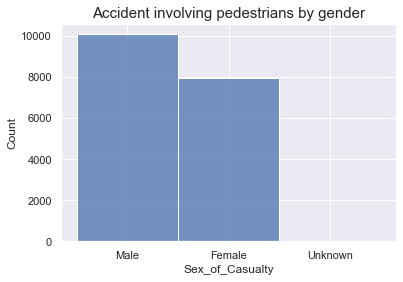

In [446]:
# Plot a chat to show accident severity on pedestrians involved and hue with gender 1: Male, 2: Female, -1: Unknown
# Plot a chat to show accident severity on motor bike accident
sns.histplot(data = ped_involved, x='Sex_of_Casualty')
plt.title ('Accident involving pedestrians by gender', size=15)

<AxesSubplot:title={'center':'Accident involving pedestrians by accident severity and gender'}, xlabel='Accident_Severity', ylabel='count'>

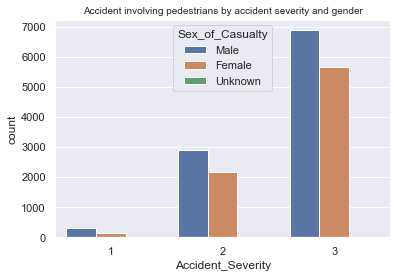

In [447]:
# Plot a chat to show accident severity on pedestrians involved and hue with gender 1: Male, 2: Female, -1: Unknown
plt.title ('Accident involving pedestrians by accident severity and gender', size=10)
sns.countplot (data = ped_involved, x='Accident_Severity', hue = "Sex_of_Casualty" )

### (d) What impact, if any, does daylight savings have on road traffic accidents in the week after it starts and stops?

- In 2019 in UK, daylight savings time began at 1am on sunday 31/03 and ended 2am on sunday 27/10.

In [470]:
accident['decimal_date'] = pd.to_datetime(accident['Date'], errors='coerce')

In [471]:
accident['Week'] = accident['decimal_date'].dt.week

<ipython-input-471-bb8fe064359c>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  accident['Week'] = accident['decimal_date'].dt.week


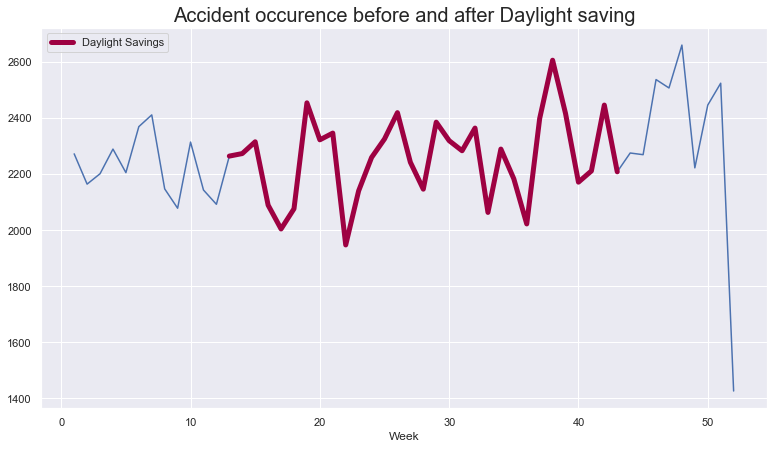

In [476]:
accident.groupby(['Week'])['Accident_Index'].count().plot(legend = False)
plt.title ('Accident occurence before and after Daylight saving', size=20)
accident.loc[accident.Week.between(13, 43)].groupby(['Week'])['Accident_Index'].count().plot(
    legend = True, cmap= plt.cm.Spectral,label = 'Daylight Savings', figsize=(13,7), linewidth = 5) 
plt.show()

In [461]:
bf_daylight_accident = len (accident[accident['day_of_year'].between(83,89)])
begin_daylight_accident = len (accident [accident['day_of_year'].between(90,96)])
bf_end_daylight_accident = len (accident[accident['day_of_year'].between (293, 299)])
end_daylight_accident = len (accident[accident['day_of_year'].between (300, 306)])

print (f"Number of accident before daylight:", bf_daylight_accident)
print (f"Number of accident begin daylight:", begin_daylight_accident)
print (f"Number of accident before end of daylight:", bf_end_daylight_accident)
print (f"Number of accident at end of daylight:", end_daylight_accident)


Number of accident before daylight: 2331
Number of accident begin daylight: 2171
Number of accident before end of daylight: 2158
Number of accident at end of daylight: 2335


### (e) What impact, if any, does sunrise and sunset times have on road traffic accidents?

- November is the month following the month daylight saving ended, with this an approximate average sunrise and sunset within the month will be 8:27am and 4:35pm respectively according to (Timeanddate, 2019). 

In [503]:
accident['decimal_month'] = pd.to_datetime(accident['Date'], errors='coerce')
accident['Month'] = accident['decimal_month'].dt.month

In [504]:
acc_in_nov = accident [accident['Month'] ==11]

In [508]:
acc_in_july = accident [accident['Month'] ==7]

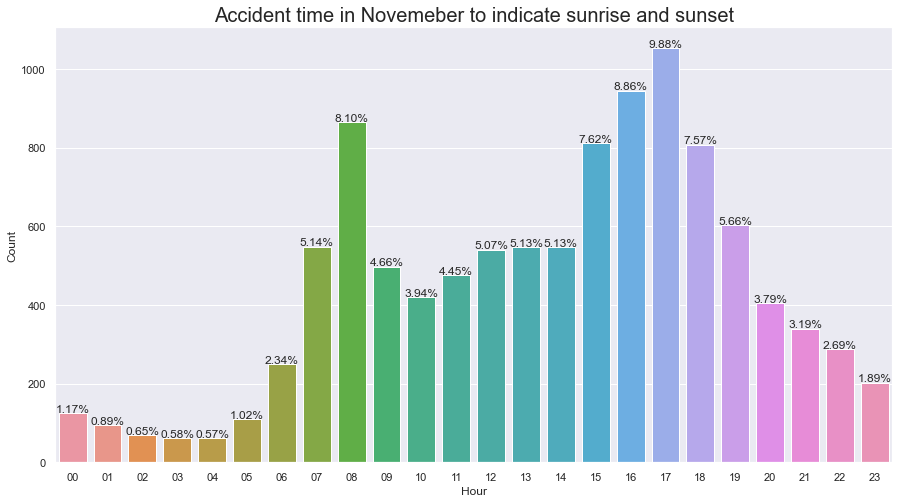

In [507]:
#Accident in November by hours of the day

sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title ('Accident time in Novemeber to indicate sunrise and sunset', size=20)
acc_hour = sns.countplot(x='Hour',data=acc_in_nov, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17'
                         ,'18','19','20','21','22','23'])
acc_hour.set(xlabel='Hour', ylabel='Count')
for p in acc_hour.patches: 
    height = p.get_height() 
    acc_hour.text(p.get_x()+p.get_width()/2., 
      height + 3, '{:1.2f}'.format((height/len(acc_in_nov))*100)+'%', ha="center")


plt.show()

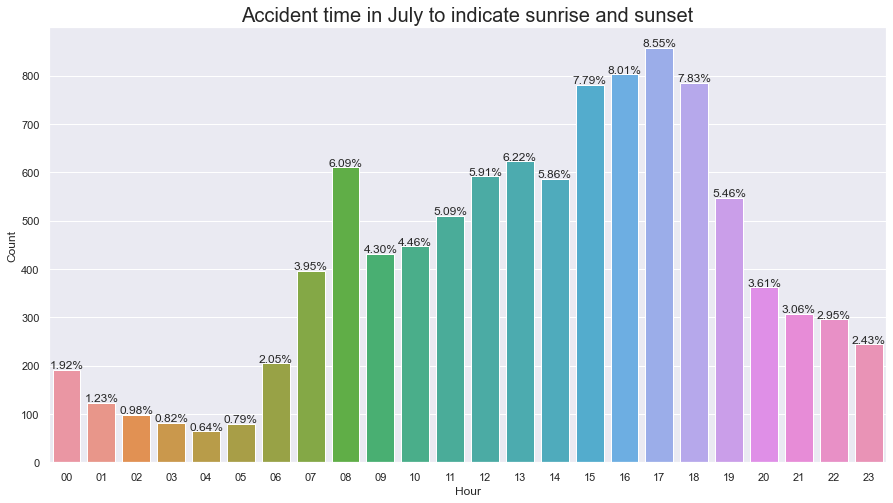

In [509]:
#Accident in July by hours of the day

sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
plt.title ('Accident time in July to indicate sunrise and sunset', size=20)
acc_hour = sns.countplot(x='Hour',data=acc_in_july, order = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17'
                         ,'18','19','20','21','22','23'])
acc_hour.set(xlabel='Hour', ylabel='Count')
for p in acc_hour.patches: 
    height = p.get_height() 
    acc_hour.text(p.get_x()+p.get_width()/2., 
      height + 3, '{:1.2f}'.format((height/len(acc_in_july))*100)+'%', ha="center")


plt.show()

### (f) Are there particular types of vehicles (engine capacity, age of vehicle, etc.) that are more frequently involved in road traffic accidents?

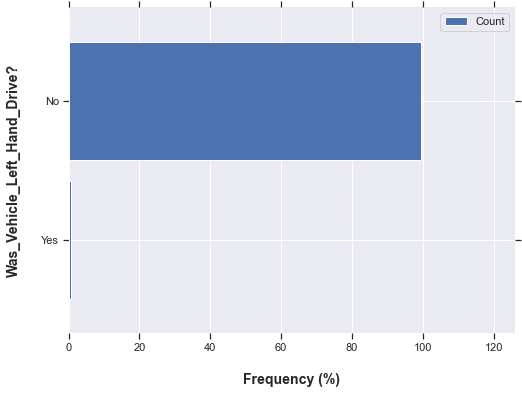

In [519]:
count_plt_drawn (Vehicles, 'Was_Vehicle_Left_Hand_Drive?', (8,6), True, is_Vehicle_left_hand_drive_dicts)

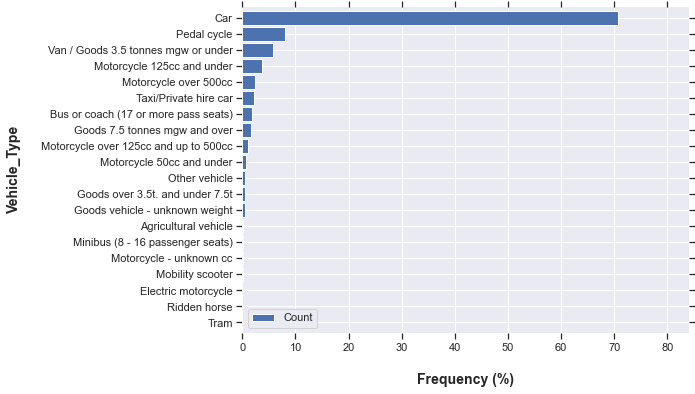

In [344]:

count_plt_drawn (Vehicles, 'Vehicle_Type', (8,6), True, Vehicle_dicts)

In [512]:

accident_Vehicles.replace ({'Vehicle_Type': Vehicle_dicts}, inplace = True)


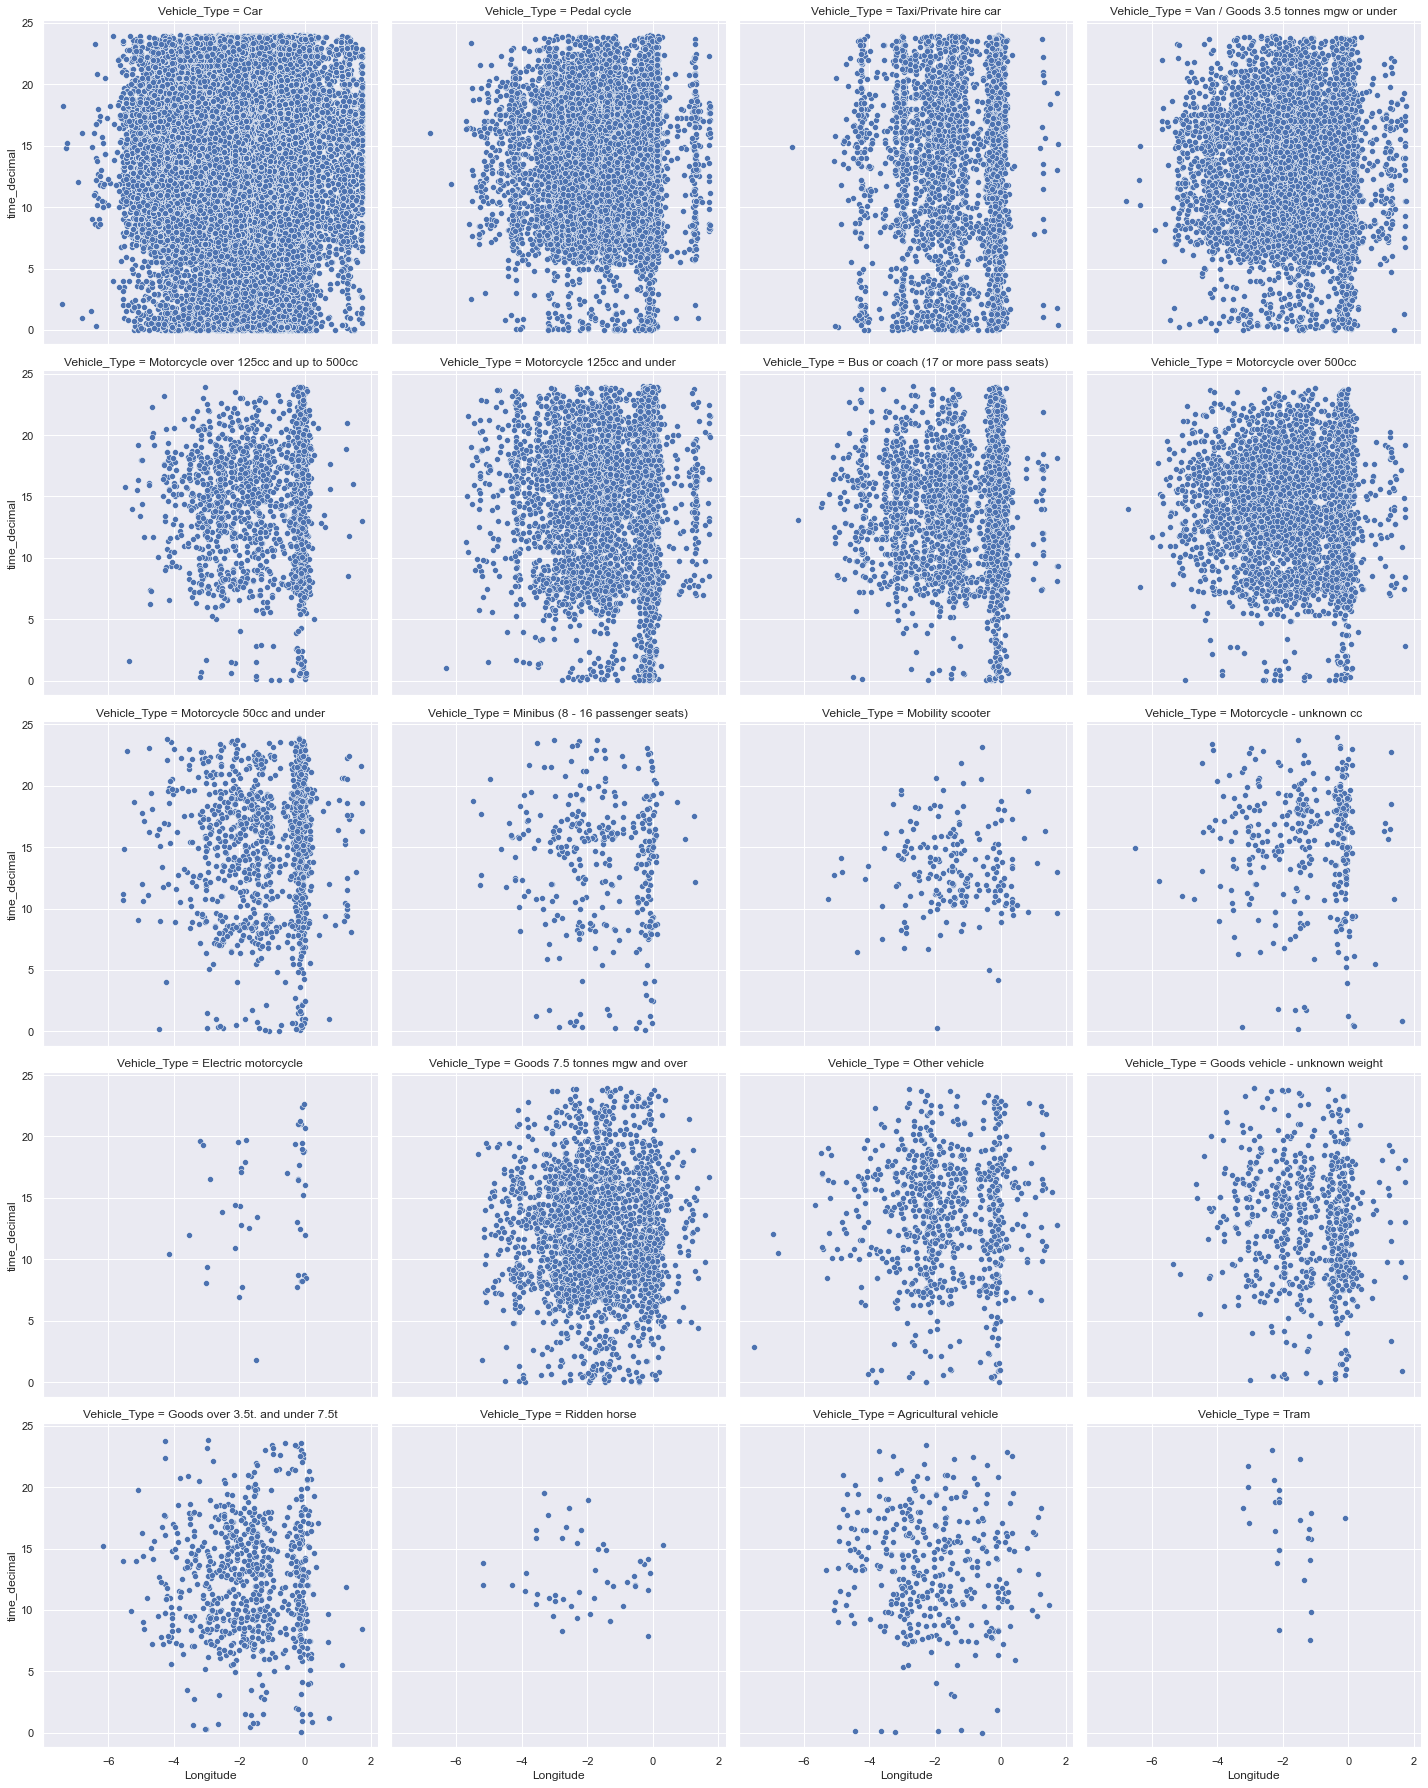

In [518]:
veh_day_plot = sns.FacetGrid (accident_Vehicles, col="Vehicle_Type", margin_titles=True, height = 5, col_wrap=4)
veh_day_plot.map(sns.scatterplot, "Longitude", "time_decimal")


### (g) Are there particular conditions (weather, geographic location, situations) that generate more road traffic accidents?

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


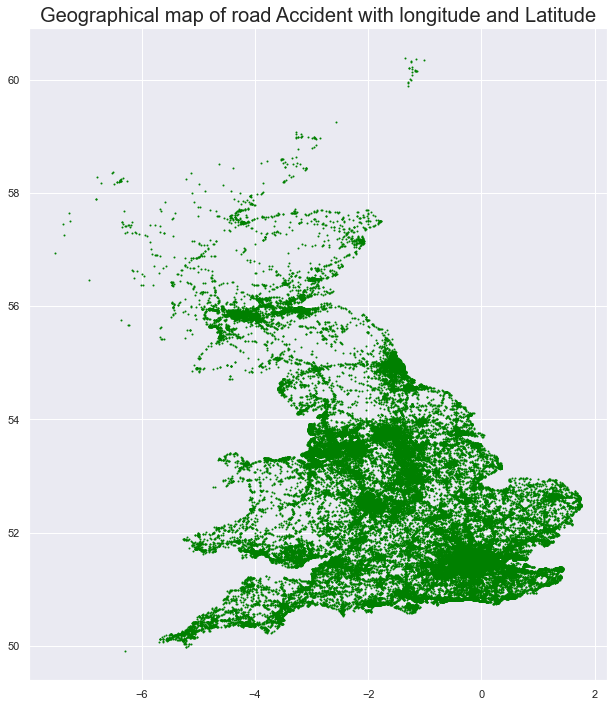

In [571]:
geometry = [Point(ab) for ab in zip (accident['Longitude'], accident['Latitude'])]
gdf = GeoDataFrame(accident, geometry=geometry)
world = gpd.read_file (gpd.datasets.get_path('naturalearth_cities'))
gdf.plot(ax=world[world.name == 'United Kingdom'].plot(figsize=(32,12)),
             marker = 'o', color = 'green', markersize=1)
plt.title ('Geographical map of road Accident with longitude and Latitude', size=20)
plt.show()


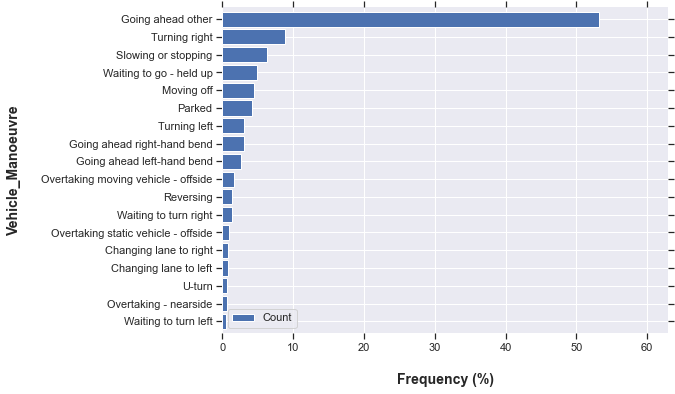

In [288]:
count_plt_drawn (Vehicles, 'Vehicle_Manoeuvre', (8,6), True, Vehicle_manoeuvre_dicts)

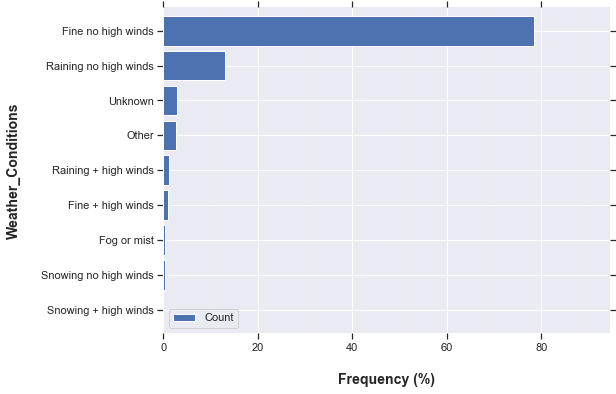

In [562]:
count_plt_drawn (accident, 'Weather_Conditions', (8,6), True, weather_condition_dicts)

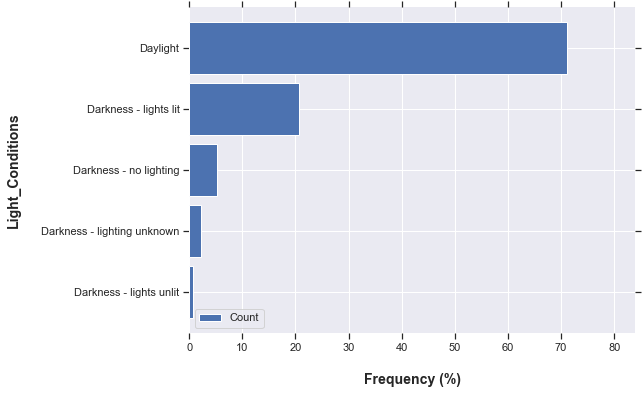

In [563]:
count_plt_drawn (accident, 'Light_Conditions', (8,6), True, light_condition_dicts)

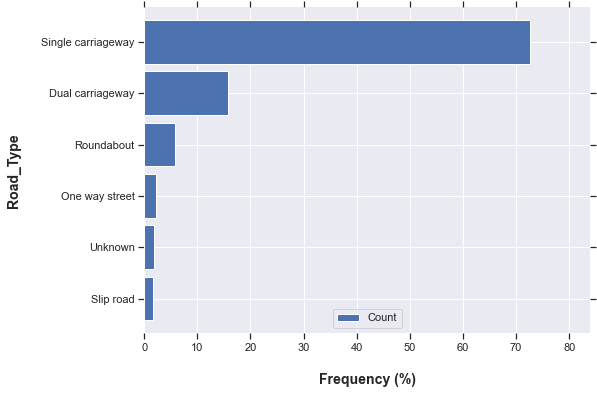

In [564]:
count_plt_drawn (accident, 'Road_Type', (8,6), True, road_type_dicts)

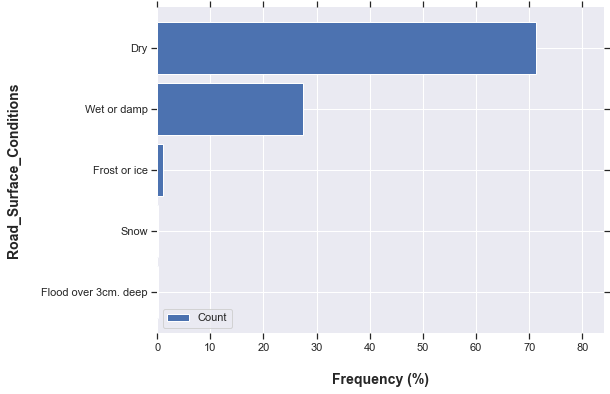

In [565]:
count_plt_drawn (accident, 'Road_Surface_Conditions', (8,6), True, road_surface_dicts)

### (h) How does driver related variables affect the outcome (e.g., age of the driver, and the purpose of the journey)?

Text(0.5, 1.0, 'Journey purpose of Driver')

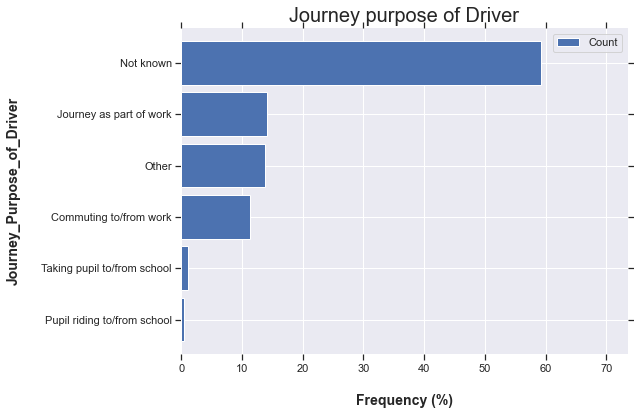

In [577]:
count_plt_drawn (Vehicles, 'Journey_Purpose_of_Driver', (8,6), True, journey_purpose_dicts)
plt.title ('Journey purpose of Driver', size=20)

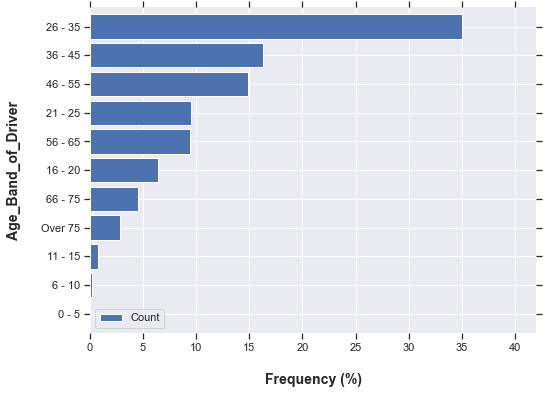

In [575]:
plt.title ('Age band of driver', size=20)
count_plt_drawn (Vehicles, 'Age_Band_of_Driver', (8,6), True, age_band_driver_dicts)

In [572]:
def view_accident_on_map (dataframe):
    geometry = [Point(ab) for ab in zip (accident['Longitude'], accident['Latitude'])]
    gdf = GeoDataFrame(accident, geometry=geometry)
    world = gpd.read_file (gpd.datasets.get_path('naturalearth_cities'))
    gdf.plot(ax=world[world.name == 'United Kingdom'].plot(figsize=(32,12)),
             marker = 'o', color = 'red', markersize=1)
    plt.title ('Geographical map of road Accident with longitude and Latitude', size=20)
    plt.show()

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


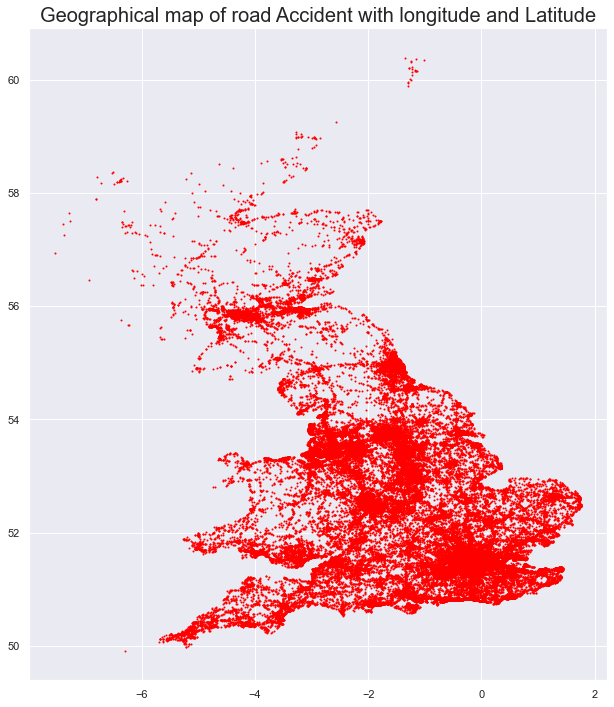

In [573]:
view_accident_on_map (accident)

### (i) Can we make predictions about when and where accidents will occur, and the severity of the injuries sustained from the data supplied to improve road safety? How well do our models compare to government models? 

- Using Apriori for data mining to get conditions under which accidents are most likely to happen

In [52]:
def association_pattern_mining_with_apriori ():
    apriori_ds = accident_Vehicles [["Vehicle_Manoeuvre", "Age_Band_of_Driver", "Accident_Severity",
                                 "Weather_Conditions", "Speed_limit", "Road_Surface_Conditions", 
                                  "Sex_of_Driver", "1st_Road_Class", "Day_of_Week"]]
    
    
    veh_manoeuvre = pd.get_dummies(apriori_ds["Vehicle_Manoeuvre"], prefix='Vehicle Manoeuvre')
    age_band_driver = pd.get_dummies(apriori_ds["Age_Band_of_Driver"], prefix='driver age band')
    acc_severity = pd.get_dummies(apriori_ds ["Accident_Severity"], prefix='Severity')
    Weather_Cond = pd.get_dummies(apriori_ds ["Weather_Conditions"], prefix='Weather Condition')
    Speed_limit = pd.get_dummies(apriori_ds ["Speed_limit"], prefix='Speed Limit')
    Road_Surface_Conditions = pd.get_dummies(apriori_ds ["Road_Surface_Conditions"], prefix='Road Surface Condition')
    Sex_of_Driver = pd.get_dummies(apriori_ds ["Sex_of_Driver"], prefix='Sex of Driver')
    Road_Class = pd.get_dummies(apriori_ds ["1st_Road_Class"], prefix='1st Road Class')
    Day_of_Week = pd.get_dummies(apriori_ds ["Day_of_Week"], prefix='Day of Week')
    
    all_apriori_ds = [veh_manoeuvre, age_band_driver, acc_severity, Weather_Cond, Speed_limit,
                  Road_Surface_Conditions, Sex_of_Driver, Road_Class, Day_of_Week]
    apriori_ds = pd.concat(all_apriori_ds, axis = 1)
    
    apriori_ds_rule = apriori (apriori_ds, min_support=0.2, use_colnames=True)
    
    rules_4mlx = association_rules(apriori_ds_rule, metric = 'confidence', min_threshold = 0.8)
    rules_4mlx ['antecedent_len'] = rules_4mlx ['antecedents'].apply(lambda x: len (x))
    rules_4mlx ['consequents_len'] = rules_4mlx ['consequents'].apply(lambda x: len (x))    
    rules_4mlx.sort_values(by = ['conviction'], ascending = False, inplace = True)
    return rules_4mlx [rules_4mlx['consequents'] == {'Severity_3'}][0:10]


In [53]:
association_pattern_mining_with_apriori ()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
12,"(driver age band_6, Road Surface Condition_1)",(Severity_3),0.260001,0.79893,0.217852,0.837891,1.048767,0.010130,1.240340,2,1
0,(driver age band_6),(Severity_3),0.356036,0.79893,0.296303,0.832227,1.041678,0.011855,1.198469,1,1
11,"(driver age band_6, Weather Condition_1)",(Severity_3),0.276948,0.79893,0.229488,0.828633,1.037179,0.008226,1.173332,2,1
3,(Sex of Driver_2),(Severity_3),0.264765,0.79893,0.219065,0.827392,1.035625,0.007536,1.164895,1,1
20,"(Speed Limit_30, 1st Road Class_3)",(Severity_3),0.243953,0.79893,0.201736,0.826947,1.035069,0.006835,1.161902,2,1
18,"(Speed Limit_30, Road Surface Condition_1)",(Severity_3),0.433934,0.79893,0.357846,0.824655,1.032200,0.011163,1.146714,2,1
36,"(Speed Limit_30, Weather Condition_1, Road Sur...",(Severity_3),0.402146,0.79893,0.330157,0.820987,1.027609,0.008870,1.123217,3,1
1,(Speed Limit_30),(Severity_3),0.592554,0.79893,0.485697,0.819667,1.025957,0.012288,1.114997,1,1
7,"(Vehicle Manoeuvre_18, Speed Limit_30)",(Severity_3),0.311889,0.79893,0.254963,0.817478,1.023217,0.005785,1.101624,2,1
15,"(Speed Limit_30, Weather Condition_1)",(Severity_3),0.468335,0.79893,0.382427,0.816567,1.022077,0.008260,1.096153,2,1


In [54]:
accident_vehicle_casualties = pd.merge (accident_Casualties, Vehicles, how= "inner",
                                        on = ["Accident_Index"])
severity_column = ['Casualty_Severity']


In [55]:

columns_to_remove = ["Accident_Index", "Date", "Time", severity_column, "Vehicle_Reference",
                    "Police_Force", "Local_Authority_(Highway)", "Did_Police_Officer_Attend_Scene_of_Accident",
                    "Local_Authority_(District)", "Number_of_Casualties", "Number_of_Vehicles", "geometry"]

In [56]:
aimed_attributes = ["Carriageway_Hazards","time_decimal","day_of_year","Road_Type","Special_Conditions_at_Site","Pedestrian_Crossing-Human_Control","Light_Conditions","Day_of_Week","Weather_Conditions","Pedestrian_Crossing-Physical_Facilities","Road_Surface_Conditions","Longitude","Latitude", "Junction_Detail","Urban_or_Rural_Area","1st_Road_Class", "Speed_limit","Sex_of_Driver", "Vehicle_Manoeuvre","Age_Band_of_Driver", "Journey_Purpose_of_Driver","Was_Vehicle_Left_Hand_Drive?", "Junction_Location","Vehicle_Type","Vehicle_Location-Restricted_Lane"]


In [57]:
#selected_attributes = ["Pedestrian_Crossing-Human_Control","Road_Type", "Day_of_Week", "Special_Conditions_at_Site", 
 #                      "Journey_Purpose_of_Driver", "Vehicle_Type", "Light_Conditions", "Weather_Conditions",
#                       "Pedestrian_Crossing-Physical_Facilities", "Longitude", "Latitude", "Road_Surface_Conditions",
#                       "Age_of_Driver", "Urban_or_Rural_Area", "Junction_Location", "Junction_Detail", "1st_Road_Class",
 #                      "Speed_limit", "Sex_of_Driver", "Vehicle_Manoeuvre"]


In [58]:
accident_vehicle_casualties

,Accident_Index,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,...,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_Band_of_Driver
0,2019010128300,1,1,1,1,58,9,3,0,0,...,0,0,0,0,0,4,1,6,1,9
1,2019010128300,1,1,1,1,58,9,3,0,0,...,0,0,0,0,0,1,1,6,3,6
2,2019010128300,1,2,2,2,-1,-1,3,0,0,...,0,0,0,0,0,4,1,6,1,9
3,2019010128300,1,2,2,2,-1,-1,3,0,0,...,0,0,0,0,0,1,1,6,3,6
4,2019010128300,1,3,2,2,-1,-1,3,0,0,...,0,0,0,0,0,4,1,6,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210435,2019984107019,1,1,1,1,22,5,3,0,0,...,0,0,0,0,0,3,1,1,1,4
210436,2019984107219,2,1,1,1,61,9,3,0,0,...,1,0,0,0,0,1,1,6,1,6
210437,2019984107219,2,1,1,1,61,9,3,0,0,...,1,0,0,0,0,0,1,6,1,9
210438,2019984107419,1,1,3,1,54,8,3,5,3,...,6,0,0,3,0,3,1,5,1,11


In [59]:
accident_vehicle_casualties = accident_vehicle_casualties.loc[:, ~accident_vehicle_casualties.columns.isin([columns_to_remove])]

In [60]:
x, y = accident_vehicle_casualties [aimed_attributes], accident_vehicle_casualties[severity_column]


In [61]:
y.head(10)

,Casualty_Severity
0,3
1,3
2,3
3,3
4,3
5,3
6,3
7,3
8,3
9,3


In [62]:
def adjust_data (x, y):
    oversample = SMOTE (sampling_strategy = "not majority")
    undersample = RandomUnderSampler (sampling_strategy = 'auto')
    balance_pipeline = Pipeline([('oversample', oversample), ('undersample', undersample)])
    return balance_pipeline.fit_resample (x, y)

In [63]:
y.value_counts()

Casualty_Severity
3                    174562
2                     33393
1                      2485
dtype: int64

In [64]:
balanced_x, balanced_y = adjust_data (x, y)

In [65]:
balanced_y.value_counts()

Casualty_Severity
1                    174562
2                    174562
3                    174562
dtype: int64

In [66]:
x_train, x_test, y_train, y_test = train_test_split(balanced_x, balanced_y, test_size=0.20, random_state = 42)

In [67]:
y_train.head(10)

,Casualty_Severity
465651,3
77745,1
470357,3
67898,1
291664,2
258401,2
36970,1
141946,1
29962,1
506319,3


In [68]:
len (aimed_attributes)

25

In [69]:
def find_most_features (count_of_features):
    selector = SelectKBest (f_classif, k='all')
    selector.fit(balanced_x[aimed_attributes], balanced_y)
    scores = (selector.scores_)
    
    argument_sort = list(np.argsort (scores))
    selected_attribute, selected_attribute_scores = [], []
    for x in range (len (aimed_attributes)-count_of_features, len (aimed_attributes)):
        value = argument_sort [x]
        
        selected_attribute.append(aimed_attributes [value])
        selected_attribute_scores.append(scores[value])
    return selected_attribute, selected_attribute_scores
    
    

In [70]:
selected_attribute, selected_attribute_scores = find_most_features(18)

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


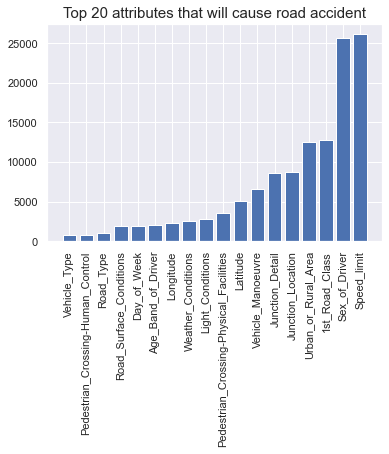

In [581]:
plt.bar(selected_attribute, selected_attribute_scores)
plt.xticks (range(len(selected_attribute)), selected_attribute, rotation = "vertical")
plt.title ('Top 20 attributes that will cause road accident', size=15)
plt.show()

In [72]:
selected_attribute

['Vehicle_Type',
 'Pedestrian_Crossing-Human_Control',
 'Road_Type',
 'Road_Surface_Conditions',
 'Day_of_Week',
 'Age_Band_of_Driver',
 'Longitude',
 'Weather_Conditions',
 'Light_Conditions',
 'Pedestrian_Crossing-Physical_Facilities',
 'Latitude',
 'Vehicle_Manoeuvre',
 'Junction_Detail',
 'Junction_Location',
 'Urban_or_Rural_Area',
 '1st_Road_Class',
 'Sex_of_Driver',
 'Speed_limit']

In [73]:
#class EvaluationResponse ():
 #   def __init__(self, training_score, validation_score, model):
  #      self.training_score = training_score
   #     self.validation_score = validation_score
    #    self.model = model

In [74]:
def evaluate_with_cv (model, x_train, x_test, y_train, y_test):
    cv = RepeatedStratifiedKFold (n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x_train[selected_attribute], y_train, scoring = 'accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print ('==============================')
    print (f"model is: {model}")
    print (f"Training score: {mean(scores)} with standard deviation of {std(scores)}")
    print ('==============================')


In [75]:
y_train

,Casualty_Severity
465651,3
77745,1
470357,3
67898,1
291664,2
...,...
259178,2
365838,3
131932,1
146867,1


In [76]:
def evaluate_for_different_models ():
    models = [DecisionTreeClassifier (), GaussianNB(), RandomForestClassifier()]
    
    for model in models:
        evaluate_with_cv(model, x_train [selected_attribute], x_test [selected_attribute], y_train, y_test)

In [77]:
%time evaluate_for_different_models()

model is: DecisionTreeClassifier()
Training score: 0.7997770653226054 with standard deviation of 0.0012264471051062018
model is: GaussianNB()
Training score: 0.49718938388749967 with standard deviation of 0.0021040306185681544
model is: RandomForestClassifier()
Training score: 0.8783858611132231 with standard deviation of 0.0009518771600583001
CPU times: user 526 ms, sys: 512 ms, total: 1.04 s
Wall time: 2min 36s


### Using Stack classifier

In [78]:
def find_stacks ():
    estimatorz = list()
    estimatorz.append (('Decision Tree', DecisionTreeClassifier()))
    estimatorz.append (('KNN', KNeighborsClassifier()))
    estimatorz.append (('Logistic Regression', LogisticRegression(max_iter=1000)))
    estimatorz.append (('Random Forest', RandomForestClassifier()))
    final_estimator = DecisionTreeClassifier()
    model = StackingClassifier (estimators=estimatorz, final_estimator=final_estimator, cv=5)
    return model

In [79]:
def add_stack_model ():
    stack_model = find_stacks ()
    fit_model = stack_model.fit(x_train[selected_attribute], y_train)
    print (f'Record of training Data is: {fit_model.score(x_train[selected_attribute], y_train)}')
    print (f'Record of validation Data is: {fit_model.score(x_test[selected_attribute], y_test)}')
    dump (fit_model, 'stackedmodel.joblib')
    return fit_model

In [80]:
%time add_stack_model ()

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver optio

Record of training Data is: 0.9289959613126212
Record of validation Data is: 0.8390364528633352
CPU times: user 4h 11min 48s, sys: 1h 37min, total: 5h 48min 49s
Wall time: 5h 15min 12s


StackingClassifier(cv=5,
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('Logistic Regression',
                                LogisticRegression(max_iter=1000)),
                               ('Random Forest', RandomForestClassifier())],
                   final_estimator=DecisionTreeClassifier())

### Using Random forest classifier

In [81]:
clf = RandomForestClassifier ()
fitted_random_forest_model = clf.fit(x_train[selected_attribute], y_train)

<ipython-input-81-da375baf044e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fitted_random_forest_model = clf.fit(x_train[selected_attribute], y_train)


In [82]:
fitted_random_forest_model.score (x_test [selected_attribute], y_test)

0.887032404666883

In [83]:
dump(fitted_random_forest_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [84]:
calibrated_clf = CalibratedClassifierCV (base_estimator = RandomForestClassifier (), cv=3)

In [85]:
calibrated_clf_fitted_model = calibrated_clf.fit(accident_vehicle_casualties [selected_attribute],
                                                accident_vehicle_casualties [severity_column])


/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:509: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, sample_weight=sw_train)
/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:509: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, sample_weight=sw_train)
/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:50

In [86]:
accident_vehicle_casualties ["Casualty_Severity"].value_counts()

3    174562
2     33393
1      2485
Name: Casualty_Severity, dtype: int64

In [87]:
calibrated_clf_fitted_model.score(accident_vehicle_casualties[selected_attribute], 
                                 accident_vehicle_casualties[severity_column])

0.8295095989355635

- Predicting casualty severity

In [88]:
non_fatal_casualties = \
accident_vehicle_casualties[accident_vehicle_casualties['Casualty_Severity']!=1].reset_index(drop=True)

In [89]:
predicted_prob = calibrated_clf_fitted_model.predict_proba(non_fatal_casualties[selected_attribute])

In [90]:
len(predicted_prob)

207955

- Delete the first predicted colomn (fatal) in probability and map the predicted probabilities to each row

In [91]:
severe_slight_prob = np.delete(predicted_prob, 0, axis=1)

In [92]:
severe_slight_prob_list = severe_slight_prob.tolist ()

In [93]:
for n in range (len (severe_slight_prob_list)):
    non_fatal_casualties.at [n, 'Predicted_Serious'] = severe_slight_prob_list[n][0]
    non_fatal_casualties.at [n, 'Predicted_Slight'] = severe_slight_prob_list[n][1]

In [94]:
non_fatal_casualties

,Accident_Index,Vehicle_Reference_x,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,...,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_Band_of_Driver,Predicted_Serious,Predicted_Slight
0,2019010128300,1,1,1,1,58,9,3,0,0,...,0,0,0,4,1,6,1,9,0.174267,0.814526
1,2019010128300,1,1,1,1,58,9,3,0,0,...,0,0,0,1,1,6,3,6,0.174148,0.814624
2,2019010128300,1,2,2,2,-1,-1,3,0,0,...,0,0,0,4,1,6,1,9,0.174267,0.814526
3,2019010128300,1,2,2,2,-1,-1,3,0,0,...,0,0,0,1,1,6,3,6,0.174148,0.814624
4,2019010128300,1,3,2,2,-1,-1,3,0,0,...,0,0,0,4,1,6,1,9,0.174267,0.814526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207950,2019984107019,1,1,1,1,22,5,3,0,0,...,0,0,0,3,1,1,1,4,0.175469,0.812914
207951,2019984107219,2,1,1,1,61,9,3,0,0,...,0,0,0,1,1,6,1,6,0.172177,0.816476
207952,2019984107219,2,1,1,1,61,9,3,0,0,...,0,0,0,0,1,6,1,9,0.172996,0.813631
207953,2019984107419,1,1,3,1,54,8,3,5,3,...,0,3,0,3,1,5,1,11,0.172124,0.816476


In [95]:
non_fatal_casualties.to_csv ('non_fatal_casualties.csv')

- Load the adjustment lookup file and get onlu 2019 accident casualty records

In [96]:
def get_2019_adjustment_lookup_data():
    adj_lookup=pd.read_csv('cas_adjustment_lookup_2019.csv')
    adj_lookup_2019=adj_lookup[adj_lookup['accident_index'].str.startswith ('2019')]
    adj_lookup_2019.reset_index(drop=True, inplace=True)
    adj_lookup_2019.rename(columns={'accident_index' : 'Accident_Index'}, inplace=True)
    return adj_lookup_2019

In [97]:
adj_lookup_2019 = get_2019_adjustment_lookup_data()

/Users/oladimejidurosaro/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [99]:
accident_casualties_lookup = pd.merge(non_fatal_casualties, adj_lookup_2019, how='left',
                                       on=['Accident_Index'])

In [104]:
def compute_adjusted_and_predicted_loss():
    for idx in accident_casualties_lookup.index:
        if accident_casualties_lookup.at[idx, 'Casualty_Severity'] ==2:
            accident_casualties_lookup.at[idx, 'Predicted_Loss'] = \
                        1 - accident_casualties_lookup.at [idx, 'Predicted_Serious']
            accident_casualties_lookup.at[idx, 'Adjusted_Loss'] = \
                        1 - accident_casualties_lookup.at [idx, 'Adjusted_Loss']
            
        elif accident_casualties_lookup.at[idx, 'Casualty_Severity'] ==3:
            accident_casualties_lookup.at[idx, 'Predicted_Loss'] = \
                        1 - accident_casualties_lookup.at [idx, 'Predicted_Slight']
            accident_casualties_lookup.at[idx, 'Adjusted_Loss'] = \
                        1 - accident_casualties_lookup.at [idx, 'Adjusted_Slight']
                                              

In [105]:
compute_adjusted_and_predicted_loss ()

In [106]:
accident_casualties_lookup

,Accident_Index,Vehicle_Reference_x,Casualty_Reference_x,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,...,Age_Band_of_Driver,Predicted_Serious,Predicted_Slight,Vehicle_Reference,Casualty_Reference_y,Adjusted_Serious,Adjusted_Slight,Injury_Based,Predicted_Loss,Adjusted_Loss
0,2019010128300,1,1,1,1,58,9,3,0,0,...,9,0.174267,0.814526,NaN,NaN,NaN,NaN,NaN,0.185474,NaN
1,2019010128300,1,1,1,1,58,9,3,0,0,...,6,0.174148,0.814624,NaN,NaN,NaN,NaN,NaN,0.185376,NaN
2,2019010128300,1,2,2,2,-1,-1,3,0,0,...,9,0.174267,0.814526,NaN,NaN,NaN,NaN,NaN,0.185474,NaN
3,2019010128300,1,2,2,2,-1,-1,3,0,0,...,6,0.174148,0.814624,NaN,NaN,NaN,NaN,NaN,0.185376,NaN
4,2019010128300,1,3,2,2,-1,-1,3,0,0,...,9,0.174267,0.814526,NaN,NaN,NaN,NaN,NaN,0.185474,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349677,2019984107019,1,1,1,1,22,5,3,0,0,...,4,0.175469,0.812914,1.0,1.0,0.074588,0.925412,0.0,0.187086,0.074588
349678,2019984107219,2,1,1,1,61,9,3,0,0,...,6,0.172177,0.816476,2.0,1.0,0.048524,0.951476,0.0,0.183524,0.048524
349679,2019984107219,2,1,1,1,61,9,3,0,0,...,9,0.172996,0.813631,2.0,1.0,0.048524,0.951476,0.0,0.186369,0.048524
349680,2019984107419,1,1,3,1,54,8,3,5,3,...,11,0.172124,0.816476,1.0,1.0,0.183316,0.816684,0.0,0.183524,0.183316


In [114]:
#def compute_mean_loss():
    
print (f"Mean loss on prediction: {np.mean (accident_casualties_lookup ['Predicted_Loss'])}")
print (f"Mean loss on adjusted: {np.mean (accident_casualties_lookup ['Adjusted_Loss'])}")
    

Mean loss on prediction: 0.28210497230983117
Mean loss on adjusted: 0.09082468252020412
